In [1]:
import madmom
import numpy as np
from scipy.signal import find_peaks
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt

import os
import json

from algorithm.onset_offset_detection import get_onset_offsets
from data.data_utils import play_audio, read_audio

%matplotlib inline

In [2]:
year = "2004"
audio_dir = os.path.join("data","synth", year)

example_piece_name = "MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1"

example_audio_path = os.path.join(audio_dir,example_piece_name+".wav")
# example_audio_path = os.path.join("data","synth", "all_notes_synth.wav")

In [3]:
# read audio
example_audio, fs = read_audio(example_audio_path)

demo_start_second = 0.5
demo_end_second = 7

demo_start_id = int(demo_start_second*fs)
demo_end_id = int(demo_end_second*fs)

example_audio = example_audio[demo_start_id:demo_end_id]

play_audio(example_audio, fs)

Reference onset offset detection tutorial: https://github.com/CPJKU/madmom_tutorials/blob/master/onset_detection.ipynb

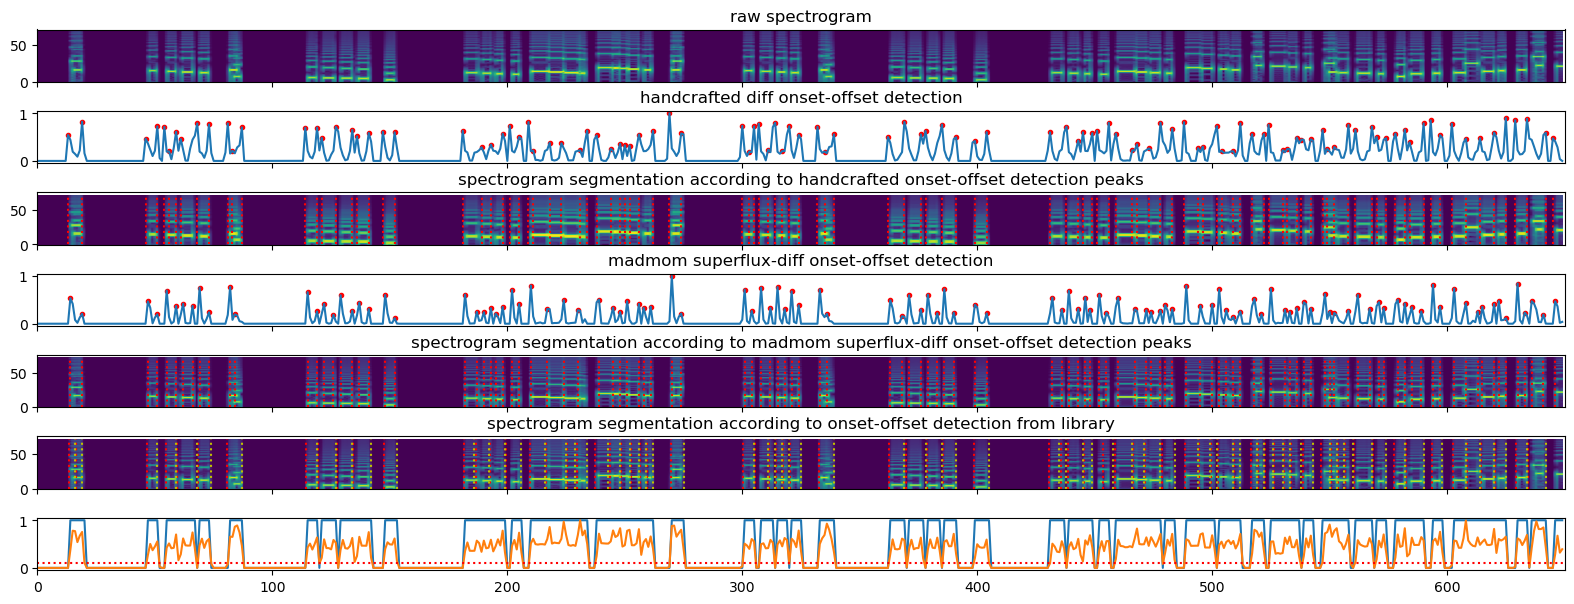

In [4]:
STFT_window_len = 1200
STFT_hop_len = 441
min_hight = 0.1
min_time_diff_second = 0.025
min_frameid_distance = int(min_time_diff_second * fs / STFT_hop_len)

example_madmom_sig = madmom.audio.signal.Signal(example_audio, sample_rate=fs)
example_madmom_frame = madmom.audio.signal.FramedSignal(example_madmom_sig, frame_size=STFT_window_len, hop_size=STFT_hop_len)
example_stft = madmom.audio.stft.STFT(example_madmom_frame)
example_spec = madmom.audio.spectrogram.Spectrogram(example_stft)
example_spec = madmom.audio.spectrogram.FilteredSpectrogram(example_spec, num_bands=12)
example_logspec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(example_spec, num_bands=12)


example_logspec_filted = maximum_filter(example_logspec, size=(1,3))
example_handcraft_diff = np.abs(example_logspec_filted[:-1] - example_logspec_filted[1:])

example_handcraft_diff = np.sum(example_handcraft_diff, axis=1)
example_handcraft_diff = np.pad(example_handcraft_diff, [(0,1)], mode='constant', constant_values=0)
example_handcraft_diff = example_handcraft_diff / example_handcraft_diff.max()

# example_superflux_diff = madmom.audio.spectrogram.SpectrogramDifference(example_logspec, positive_diffs=True, diff_max_bins=1)
example_superflux_diff =  madmom.features.onsets.spectral_flux(example_logspec, diff_frames=1)
example_superflux_diff = example_superflux_diff / example_superflux_diff.max()

example_onset_offsets, peak_finding_result_dict = find_peaks(
    example_handcraft_diff, 
    height = min_hight, 
    threshold = None, 
    distance = min_frameid_distance, 
    prominence = None, 
    width = None, 
    wlen = None, rel_height = 0.5, plateau_size = None
)

example_onset_offsets2, peak_finding_result_dict2 = find_peaks(
    example_superflux_diff, 
    height = min_hight, 
    threshold = None, 
    distance = min_frameid_distance, 
    prominence = None, 
    width = None, 
    wlen = None, rel_height = 0.5, plateau_size = None
)

fig, ax = plt.subplots(7,1, figsize=(16,6), sharex = True)
fig.tight_layout()
xmax = int(demo_end_id/STFT_hop_len)-int(demo_start_id/STFT_hop_len)
ax[0].imshow(example_logspec.T, origin='lower', aspect='auto')
ax[0].set_title("raw spectrogram")

ax[1].plot(example_handcraft_diff / example_handcraft_diff.max())
ax[1].set_xlim([0, xmax])
ax[1].scatter(example_onset_offsets, peak_finding_result_dict["peak_heights"], s=9, c="r")
ax[1].set_title("handcrafted diff onset-offset detection")

ax[2].imshow(example_logspec_filted.T, origin='lower', aspect='auto')
ax[2].vlines(example_onset_offsets, ymin=0, ymax=example_logspec.shape[1], colors="r", linestyles="dotted")
ax[2].set_title("spectrogram segmentation according to handcrafted onset-offset detection peaks")

ax[3].plot(example_superflux_diff / example_superflux_diff.max())
ax[3].scatter(example_onset_offsets2, peak_finding_result_dict2["peak_heights"], s=9, c="r")
ax[3].set_title("madmom superflux-diff onset-offset detection")

ax[4].imshow(example_logspec.T, origin='lower', aspect='auto')
ax[4].vlines(example_onset_offsets2, ymin=0, ymax=example_logspec.shape[1], colors="r", linestyles="dotted")
ax[4].set_title("spectrogram segmentation according to madmom superflux-diff onset-offset detection peaks")

example_onset_ids_audio, example_offset_ids_audio = get_onset_offsets(example_audio, fs)
ax[5].imshow(example_logspec.T, origin='lower', aspect='auto')
ax[5].vlines((example_onset_ids_audio / STFT_hop_len)+0.5, ymin=0, ymax=example_logspec.shape[1], colors="r", linestyles="dotted")
ax[5].vlines(example_offset_ids_audio / STFT_hop_len, ymin=0, ymax=example_logspec.shape[1], colors="y", linestyles="dotted")
ax[5].set_title("spectrogram segmentation according to onset-offset detection from library")

power_vec = np.quantile(example_logspec_filted, 0.4, axis = 1)
thres = example_logspec_filted[example_logspec_filted >= example_logspec_filted.mean()].mean() * 0.1
ax[6].plot(power_vec >= thres)
ax[6].plot(power_vec / power_vec.max())
ax[6].hlines(np.array(thres) / power_vec.max(), xmin=0, xmax = xmax, colors="r", linestyles="dotted")

# Plot demo with groud-truth piano-roll

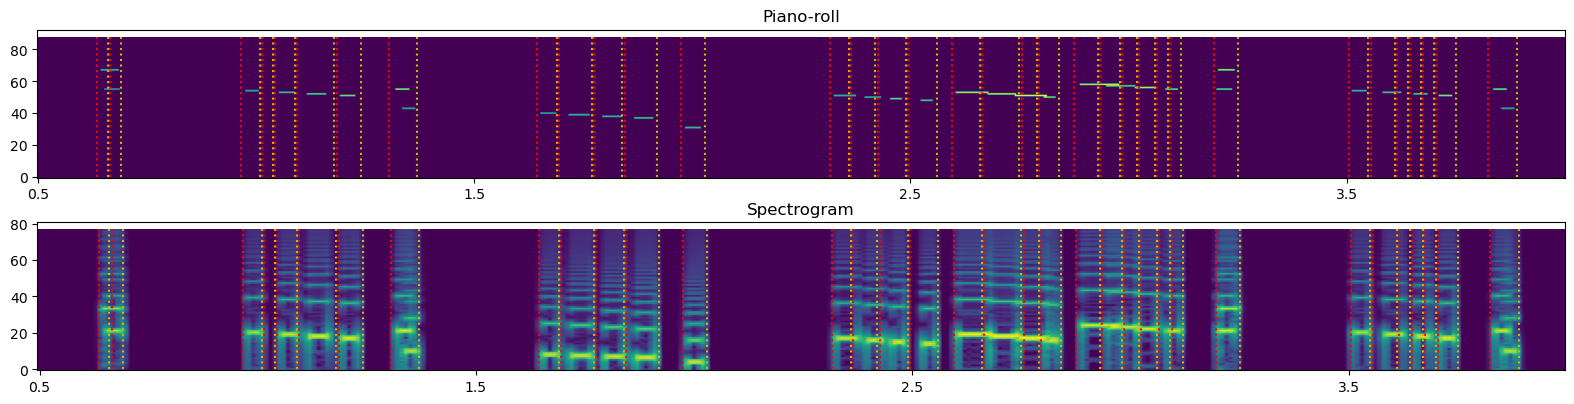

In [5]:
import mido
import os
from data.data_utils import maestro_get_tick_per_second, maestro_midi_to_note_list, remove_short_notes, maestro_note_list_to_piano_roll
from algorithm.onset_offset_detection import get_onset_offsets
from hyperparameters import STFT_HOP_SEC, STFT_WINDOW_LEN_SEC

year = "2004"
audio_dir = os.path.join("data","synth", year)
midi_dir = os.path.join("data","midi_no_cc", year)
demo_start_second = 0.5
demo_end_second = 4

example_piece_name = "MIDI-Unprocessed_SMF_17_R1_2004_03-06_ORIG_MID--AUDIO_20_R2_2004_12_Track12_wav--1"

example_audio_path = os.path.join(audio_dir,example_piece_name+".wav")
example_midi_path = os.path.join(midi_dir,example_piece_name+".midi")

# get piano roll
midi_obj = mido.MidiFile(example_midi_path)
tick_per_sec = maestro_get_tick_per_second(midi_obj)

note_list = maestro_midi_to_note_list(midi_obj)
note_list = remove_short_notes(note_list, min_len = 20)
piano_roll = maestro_note_list_to_piano_roll(note_list, pitch_range = 88, lowest_pitch = 21)
demo_start_score_id = int(demo_start_second*tick_per_sec)
demo_end_score_id = int(demo_end_second*tick_per_sec)
piano_roll = piano_roll[demo_start_score_id:demo_end_score_id]
piano_roll_len = piano_roll.shape[0]
piano_roll_ticks = np.arange(0,piano_roll_len,tick_per_sec)
piano_roll_ticks_show = (piano_roll_ticks + demo_start_score_id)/tick_per_sec

# get spectrogram
example_audio, fs = read_audio(example_audio_path)

demo_start_id = int(demo_start_second*fs)
demo_end_id = int(demo_end_second*fs)

example_audio = example_audio[demo_start_id:demo_end_id]
STFT_hop_len = int(STFT_HOP_SEC*fs)
STFT_window_len = int(fs*STFT_WINDOW_LEN_SEC)

example_madmom_sig = madmom.audio.signal.Signal(example_audio, sample_rate=fs)
example_madmom_frame = madmom.audio.signal.FramedSignal(example_madmom_sig, frame_size=STFT_window_len, hop_size=STFT_hop_len)
example_stft = madmom.audio.stft.STFT(example_madmom_frame)
example_spec = madmom.audio.spectrogram.Spectrogram(example_stft)
example_spec = madmom.audio.spectrogram.FilteredSpectrogram(example_spec, num_bands=12)
example_logspec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(example_spec, num_bands=12)

example_onset_ids_audio, example_offset_ids_audio = get_onset_offsets(example_audio, fs)
spectrogram_len = example_logspec.shape[0]
spectrogram_ticks = np.arange(0,spectrogram_len,int(1/STFT_HOP_SEC))
spectrogram_ticks_start = demo_start_second/STFT_HOP_SEC
spectrogram_ticks_show = (spectrogram_ticks+spectrogram_ticks_start) / int(1/STFT_HOP_SEC)

onsets_sec = (example_onset_ids_audio / STFT_hop_len) * STFT_HOP_SEC + 0.005
offsets_sec = (example_offset_ids_audio / STFT_hop_len) * STFT_HOP_SEC

fig, ax = plt.subplots(2,1, figsize=(16,4), sharex = False)
fig.tight_layout()
ax[0].imshow(piano_roll.T, origin='lower', aspect='auto')
ax[0].vlines(onsets_sec*tick_per_sec, ymin=0, ymax=88, colors="r", linestyles="dotted")
ax[0].vlines(offsets_sec*tick_per_sec, ymin=0, ymax=88, colors="y", linestyles="dotted")
ax[0].set_title("Piano-roll")
ax[0].set_xticks(piano_roll_ticks, labels=piano_roll_ticks_show)
ax[1].imshow(example_logspec.T, origin='lower', aspect='auto')
ax[1].vlines((example_onset_ids_audio / STFT_hop_len)+0.5, ymin=0, ymax=example_logspec.shape[1], colors="r", linestyles="dotted")
ax[1].vlines(example_offset_ids_audio / STFT_hop_len, ymin=0, ymax=example_logspec.shape[1], colors="y", linestyles="dotted")
ax[1].set_title("Spectrogram")
ax[1].set_xticks(spectrogram_ticks, labels=spectrogram_ticks_show)